Note: you may need to restart the kernel to use updated packages.
Model saved to ../models/phishing_rf_model.pkl
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     16098

    accuracy                           1.00     16098
   macro avg       1.00      1.00      1.00     16098
weighted avg       1.00      1.00      1.00     16098

Only one class present in y_test; skipping ROC AUC and ROC curve (need both classes).
Model saved to ../models/phishing_rf_model.pkl
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     16098

    accuracy                           1.00     16098
   macro avg       1.00      1.00      1.00     16098
weighted avg       1.00      1.00      1.00     16098

Only one class present in y_test; skipping ROC AUC and ROC curve (need both classes).


/home/lerato/phishing-risk-detection-project/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


SHAP summary plot saved to ../models/phishing_shap_summary.png


/home/lerato/phishing-risk-detection-project/.venv/lib/python3.10/site-packages/shap/plots/_force_matplotlib.py:325: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


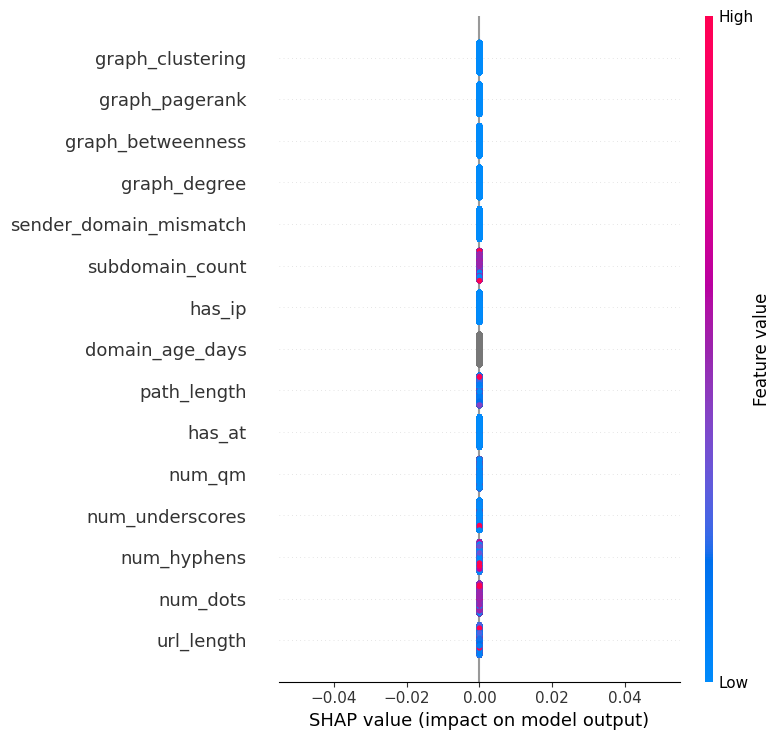

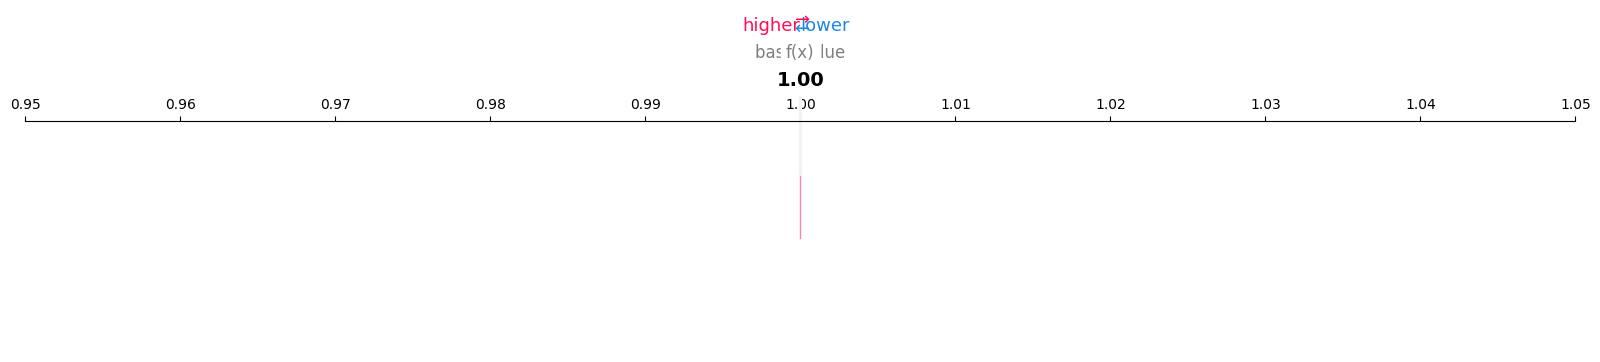

In [5]:
# 04-model-training.ipynb
# Model Training & SHAP Explainability

"""
## 04 - Model Training and Explainability

This notebook:
1. Loads `phishing_graph_features.csv` with all features & labels.
2. Splits into train/test.
3. Trains a RandomForestClassifier for phishing detection.
4. Evaluates performance (accuracy, precision, recall, F1, ROC-AUC).
5. Uses SHAP to generate global and local explanations.
6. Saves model and explanation visuals.
"""

#%%
# 1. Imports and Config
# Install missing packages in the notebook environment
%pip install joblib shap --quiet

import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import shap

# Paths
FEATURE_CSV = os.path.join('..','data','processed','phishing_graph_features.csv')
MODEL_PATH = os.path.join('..','models','phishing_rf_model.pkl')
SHAP_SUMMARY_PLOT = os.path.join('..','models','phishing_shap_summary.png')

#%%
# 2. Load Data
df = pd.read_csv(FEATURE_CSV)
X = df.drop(columns=['label','url','sender_domain','domain'])  # drop non-numeric
y = df['label']

#%%
# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

#%%
# 4. Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
joblib.dump(clf, MODEL_PATH)
print("Model saved to", MODEL_PATH)

#%%
# 5. Evaluate Performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

import numpy as np
# Only compute ROC AUC if both classes are present in y_test
if np.unique(y_test).size > 1:
    # obtain score/probability for the positive class in a robust way
    scores = None
    if hasattr(clf, 'predict_proba'):
        proba = clf.predict_proba(X_test)
        # proba may be (n_samples, 2) or (n_samples,1) in degenerate cases
        if getattr(proba, 'ndim', 0) == 2 and proba.shape[1] > 1:
            scores = proba[:, 1]
        else:
            # fallback to the single column available
            scores = proba.ravel()
    elif hasattr(clf, 'decision_function'):
        scores = clf.decision_function(X_test)
    else:
        # last resort: use predicted labels (not ideal for ROC)
        scores = clf.predict(X_test)
    try:
        roc_auc = roc_auc_score(y_test, scores)
        fpr, tpr, _ = roc_curve(y_test, scores)
        print(f"ROC AUC: {roc_auc:.3f}")

        plt.figure()
        plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Phishing Detection')
        plt.legend()
        plt.show()
    except Exception as e:
        print('Could not compute ROC AUC:', e)
else:
    print('Only one class present in y_test; skipping ROC AUC and ROC curve (need both classes).')

#%%
# 6. SHAP Explainability (robust to single-class / binary outputs)
import numpy as np

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# shap_values/explainer.expected_value can have different shapes depending on SHAP version:
# - list with one array per class: [ (n_samples,n_features), ... ]
# - ndarray with shape (n_classes, n_samples, n_features)
# - ndarray with shape (n_samples, n_features) for a single-output explanation
# Pick the "positive" class explanation when available, otherwise fallback to the only available explanation.
sv_for_pos_class = None
ev_for_pos_class = None

# Handle list-like return (common)
if isinstance(shap_values, list):
    sv_for_pos_class = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    sv_arr = np.array(shap_values)
    if sv_arr.ndim == 3:
        # (n_classes, n_samples, n_features)
        sv_for_pos_class = sv_arr[1] if sv_arr.shape[0] > 1 else sv_arr[0]
    elif sv_arr.ndim == 2:
        # (n_samples, n_features)
        sv_for_pos_class = sv_arr
    else:
        # unexpected shape: try to coerce to (n_samples, n_features)
        sv_for_pos_class = sv_arr.reshape(sv_arr.shape[0], -1)

# expected_value can be scalar or array-like (per-class)
ev = explainer.expected_value
if hasattr(ev, "__len__"):
    try:
        ev_for_pos_class = ev[1] if len(ev) > 1 else ev[0]
    except Exception:
        ev_for_pos_class = ev
else:
    ev_for_pos_class = ev

# Ensure numpy array for consistent indexing
sv_for_pos_class = np.array(sv_for_pos_class)

# Global summary plot
shap.summary_plot(sv_for_pos_class, X_test, show=False)
plt.savefig(SHAP_SUMMARY_PLOT, bbox_inches='tight')
print("SHAP summary plot saved to", SHAP_SUMMARY_PLOT)

#%%
# 7. Local Explanation Example
i = 0  # positional index of test instance (0..n-1)
data_row = X_test.iloc[[i]]

# Prepare scalar expected value if possible
if hasattr(ev_for_pos_class, "__len__"):
    try:
        # if it's an array-like with single element, use that element
        ev_scalar = float(ev_for_pos_class) if np.size(ev_for_pos_class) == 1 else ev_for_pos_class
    except Exception:
        ev_scalar = ev_for_pos_class
else:
    ev_scalar = ev_for_pos_class

# pick the shap-values for the instance
sv_instance = sv_for_pos_class[i]

# Force plot (matplotlib)
shap.force_plot(ev_scalar, sv_instance, data_row, matplotlib=True)
plt.show()
